In [ ]:
def extract_steps(task_num, model_path):
    task_path = os.path.join(model_path, f'{task_num}_runtime.log')
    with open(task_path, 'r') as f:
      logs = f.read()
      if "</answer>" in logs:

        first_attempt = logs[:logs.find("</answer>")]
        thoughts = "".join(pattern.findall(first_attempt))

      else:

        thoughts = "".join(pattern.findall(logs))

    return thoughts

In [ ]:
gemini_63 = {
    "File": "{task-num}_runtime.log",
    "extractions": [
{
            "goal": "Environmment/interface use",
            "breakdown": "Environment bottleneck",
            "evidence_breakdown": '''RESPONSE: I see a "Can't update Chrome" pop-up that is blocking the view.''',
            "workarounds": [
                {
                    "action": "Environment re-orientation",
                    "workaround_num_attempts": "1",
                    "evidence_action_1": "I need to close it first to interact with the dashboard."
                }
            ],
},
{
            "goal": "Data retrieval",
            "breakdown": "Visualization usage failure",
            "evidence_breakdown": "RESPONSE: I have hovered over the peaks for both counties, but the tooltips with the exact values are not appearing in the observations.",
            "workarounds": [
                {
                    "action": "Tool re-orientation",
                    "workaround_num_attempts": "1",
                    "evidence_action_1": "RESPONSE: I will now try clicking on the peaks to see if that makes the tooltip appear and stay."
                }]
},
{
            "goal": "Dashboard navigation",
            "breakdown": "Navigation tool usage failure",
            "evidence_breakdown": '''The previous step of selecting "Harris County" did not work as expected, as the filter dropdown is still open.''',
            "workarounds": [
                {
                    "action": "Tool re-orientation",
                    "workaround_num_attempts": "2",
                    "evidence_action_1": '''I will try again, this time clicking directly on the "Harris County" checkbox to select it, and then clicking outside the filter to apply it.It seems my previous actions have resulted in no data being displayed. I need to reset the filter to show all the data again. I will click the "(All)" checkbox to re-select all counties and then click outside the filter to apply the change.'''
                }]
},
{
            "goal": "Information synthesis/calculation",
            "breakdown": "Planning failure",
            "evidence_breakdown": "RESPONSE: I have made an error in the previous steps by not recording the peak value for Harris County before changing the filter. ",
            "workarounds": [
                {
                    "action": "State change/reversion",
                    "workaround_num_attempts": "1",
                    "evidence_action_1": '''I need to go back to the Harris County data to find its peak.'''
                }
            ],
        }
]
}


In [ ]:
jedi_263 = {
    "File": "{task-num}_runtime.log",
    "extractions": [

{
            "goal": "Data retrieval",
            "breakdown": "Visualization usage failure",
            "evidence_breakdown": '"The current view does not provide data on "Inventory" or "New Listings."',
"workarounds": [{
                    "action": "Modality shift",
                    "workaround_num_attempts": "1",
                    "evidence_action_1": '"Click on the "Data Download" tab to explore if it contains relevant data for "Inventory" and "New Listings."'
                		    },
{
                    "action": "State change/reversion",
                    "workaround_num_attempts": "1",
                    "evidence_action_1": '"Clicking on the "Inventory" tab seems logical to check for data related to Inventory."'
                		    }
]
}]
}


In [ ]:
# @title
from google.colab import drive
import re
import os
from openai import OpenAI, RateLimitError
import time
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


client = OpenAI(api_key = "sk...")

drive.mount('/content/drive')

# Loop through all log files


#base paths for all VLMs
base_path_jedi = '/content/drive/MyDrive/collected_logs_Jedi'
base_path_gemini = '/content/drive/MyDrive/collected_logs_Gemini'


summary_collections = []
pattern = re.compile(r'Generating.*?```.*?```', flags=re.DOTALL)

goals = [
    "Environment/interface use",
    "Data retrieval",
    "Dashboard navigation",
    "Information synthesis/Calculation"
]

breakdowns = [
    "Navigation tool usage failure",
    "Environment bottleneck",
    "Planning failure",
    "Visualization usage failure"
]
workarounds = [
    "Recalibrate mouse position",
    "Tool re-orientation",
    "Change tool/widget",
    "Modality shift",
    "Environment re-orientation"
    "State change/reversion",
    "Wait",
    "Quit/return FAIL"
]

goal_breakdown_mappings = {goal:{breakdown: {workaround:0 for workaround in workarounds} for breakdown in breakdowns} for goal in goals}

#obtaining the contents of file 63 which was chosen for few shot prompting
steps_63 = extract_steps(63, base_path_gemini)
#obtaining the contents of file 263 which was chosen for few shot prompting

steps_263 = extract_steps(263, base_path_jedi)

json_file = "/content/drive/MyDrive/all_summaries.txt"
with open(json_file, 'w') as curr_file:

  for task_num in range(0,291):
    task_path = os.path.join(base_path_gemini, f'{task_num}_runtime.log')
    with open(task_path, 'r') as f:
      logs = f.read()
      if "</answer>" in logs:
        #print('yes')
        first_attempt = logs[:logs.find("</answer>")]
        thoughts = "".join(pattern.findall(first_attempt))
        #print(thoughts)
      else:

        thoughts = "".join(pattern.findall(logs))

      contents_task = f'''I am giving you the VLM generated reasoning steps here: {thoughts}.

    Note: Don't mistake common task workflows as a breakdown, the first view not being in the right state and parsing issues are not breakdowns. Breakdowns occur only when there are general impediments to completing and reasoning with the task at hand.
              If there are none at all, just return an empty list for extractions.
              Output only JSON using this design format, replacing variable placeholders as needed::]
              {{ "File": "{task_num}_runtime.log",
               "extractions": [ {{
                   "goal": "string for goal 1",
                   "breakdown": "issue_faced",
                   "evidence_breakdown": "log_quote",
                   "workarounds": [
                  {{"action": "workaround_x",
                     "workaround_num_attempts": "N (Must be an integer)",
                      "evidence_action_1": "string A from reasoning logs",
                    "workaround_num_attempts": "P (Must be an integer)",
                    "evidence_action_1": "string A from reasoning logs."
                }},
                {{ "action": "workdaround_y",
                  "workaround_num_attempts": "Z (Must be an integer)",
                  "evidence_action_2": "string B from reasoning logs" }}
 ],
        }}
]
}}
'''


    contents = [
      {
          "type": "text",
          "text": contents_task
      }
  ]
  #making sure every logged file is looked through, and any RateLimitError is dealt with
    has_run = False
    while has_run == False:
      try:
        response = client.chat.completions.create(
            model="gpt-4o",
            response_format={"type": "json_object"},
            messages=[
                {"role": "system", "content": f"""You are an analyst summarizing logged task executions taken by Vision Language Models in response to an interactive dashboard question answering task.
                Given a series of reasoning steps taken by the VLM, you must identify all the breakdowns and workarounds seen when accomplishing specific goals.
                Rules:
                -You must output in JSON format only.
                -The breakdown, workarounds, and goals must be taken from the following lists:
                Breakdowns: f{breakdowns}
                Workarounds: f{workarounds}
                Goals: f{goals}
                -The evidence strings must be taken directly as given in the reasoning steps.
                """},

                {"role": "user",
                "content": f"{steps_63}" },
                {
                  "role": "assistant",
                  "content": f"{gemini_63}"
                },
                {"role": "user",
                "content": f"{steps_263}" },
                {
                  "role": "assistant",
                  "content": f"{jedi_263}"
                },
                {
                    "role": "user",
                    "content": contents
                    }
                        ])
        has_run = True
      except RateLimitError as e:
          time.sleep(25)

    print(response.choices[0].message.content)
    summary_collections.append(response.choices[0].message.content)

  curr_file.write(str(summary_collections))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generating content with Gemini model: gemini-2.5-pro
RESPONSE: I need to first close the "Can't update Chrome" pop-up to interact with the dashboard. Then, I will find the peak values for violent crimes in Harris County (orange line) and Brazoria County (green line) by hovering over the highest points of their respective lines. After getting the values, I will calculate the difference and round it to the nearest hundred.

```python
import pyautogui
import time

# Close the "Can't update Chrome" dialog
pyautogui.click(x=497, y=63)
time.sleep(1)
```Generating content with Gemini model: gemini-2.5-pro
RESPONSE: Now that the pop-up is closed, I will hover over the peak of the Harris County (orange) line to get the exact value of the violent crimes reported. The peak appears to be in the year 2011.```python
import pyautogui
import time

# Hover over the peak of th

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import json
import difflib

# print(summary_collections)



def parse_strategy_workarounds(goal_breakdown_mappings, extractions):
  "'parse functions to quantify a given extractions breakdown-workaround mappings for the corresponding goal'"
    for summmaries in extractions.get("extractions"):
      goal = summmaries.get("goal")
      breakdown = summmaries.get("breakdown")
      evidence_breakdown = summmaries.get("evidence_breakdown")
      num_workarounds = len(summmaries.get("workarounds"))
      for workaround in summmaries.get("workarounds"):
        workaround_action = workaround.get("action")
        workaround_num_attempts = workaround.get("workaround_num_attempts")
        workaround_evidence = workaround.get("evidence")
        #print(workaround_action)
        try:
          attempts = int(workaround_num_attempts)
          #print(attempts)
        except ValueError:
          attempts = 0
        try:

          goal_breakdown_mappings[goal][breakdown][workaround_action] += attempts
        except KeyError:

          #For the case of keyErrors because the generated summaries were not exactly following
          new_goal = difflib.get_close_matches(goal, goals, n=1, cutoff=0.0)[0]
          new_breakdown = difflib.get_close_matches(breakdown, breakdowns, n=1, cutoff=0.0)[0]
          new_workaround = difflib.get_close_matches(workaround_action, workarounds, n=1, cutoff=0.0)[0]

          print(goal)
          print(breakdown)
          print(workaround_action)
          goal_breakdown_mappings[new_goal][new_breakdown][new_workaround] += attempts

#parse_strategy_workarounds(goal_breakdown_mappings, example)


for summary in summary_collections:
  #print(summary)
  try:
    example = json.loads(summary)
    parse_strategy_workarounds(goal_breakdown_mappings, example)
  except json.JSONDecodeError:
    print(f"Skipping invalid JSON: {summary}")

with open("/content/drive/MyDrive/final_sumaries_gemini.txt", "w", encoding="utf-8") as final:
    for item in summary_collections:
        final.write(item)

print(goal_breakdown_mappings)

Dashboard navigation
Planning failure
Environment re-orientation
Environment/interface use
Environment bottleneck
Environment re-orientation
Data retrieval
Environment bottleneck
State change/reversion
Environment/interface use
Environment bottleneck
Environment re-orientation
Data retrieval
Environment bottleneck
Environment re-orientation
Data retrieval
Environment bottleneck
State change/reversion
Data retrieval
Environment bottleneck
Environment re-orientation
Data retrieval
Navigation tool usage failure
Environment re-orientation
Dashboard navigation
Environment bottleneck
Environment re-orientation
Data retrieval
Navigation tool usage failure
State change/reversion
Information synthesis/Calculation
Planning failure
State change/reversion
Environment/interface use
Environment bottleneck
Environment re-orientation
Data retrieval
Visualization usage failure
State change/reversion
Environment/interface use
Environment bottleneck
Environment re-orientation
Data retrieval
Planning fail

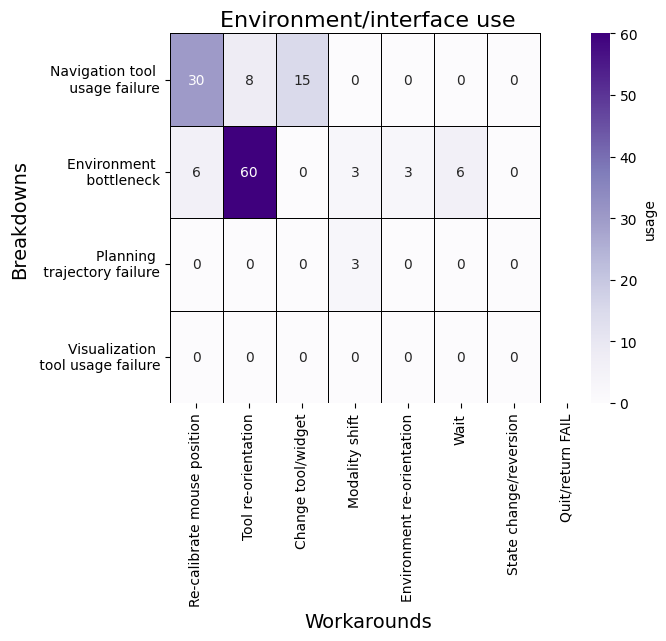

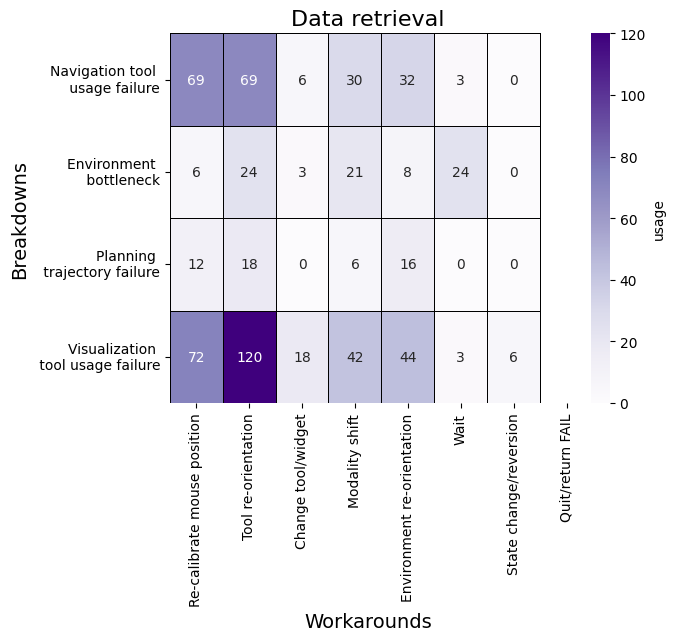

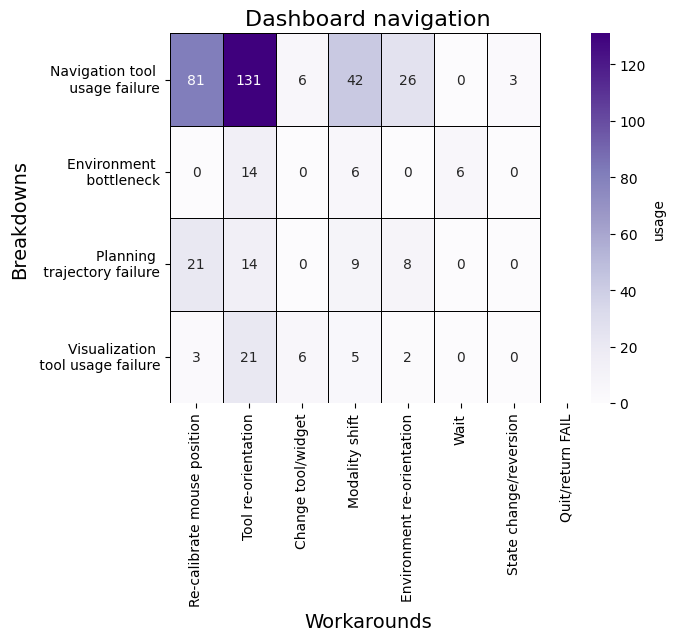

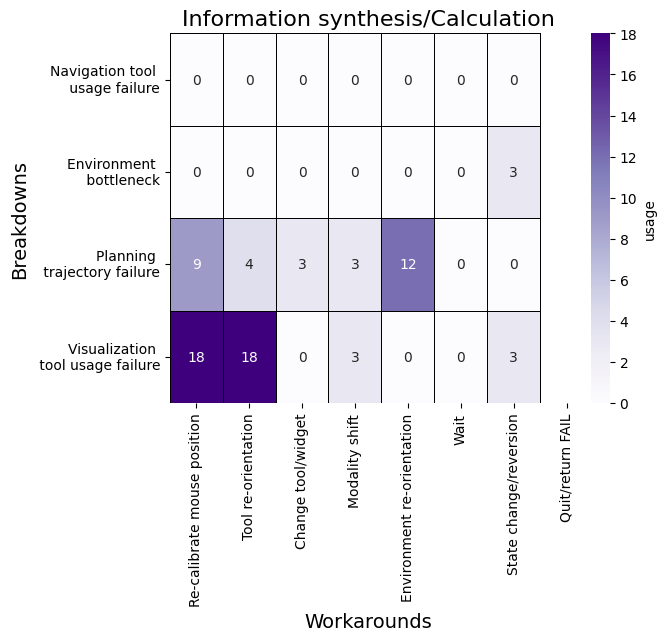

[[0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 3],
 [9, 4, 3, 3, 12, 0, 0],
 [18, 18, 0, 3, 0, 0, 3]]

In [ ]:
breakdowns = [
    "Navigation tool \n usage failure",
    "Environment \n bottleneck",
    "Planning \n trajectory failure",
    "Visualization \n tool usage failure"
]

workarounds = [
    "Re-calibrate mouse position",
    "Tool re-orientation",
    "Change tool/widget",
    "Modality shift",
    "Environment re-orientation",
    "Wait",
    "State change/reversion",
    "Quit/return FAIL"
]
def create_heatmap(goal_data, goal):
#Creating our he
  sns.heatmap(goal_data, cmap='Purples', xticklabels= workarounds, yticklabels= breakdowns, linewidths=.5, linecolor='black', cbar_kws={'label': 'usage'}, annot=True, fmt='g')

  plt.title(f"{goal}", fontsize=16)
  plt.xlabel("Workarounds", fontsize=14)
  plt.ylabel("Breakdowns", fontsize=14)
  plt.show()
#Turn the nested dictionary into a 2d array and show heatmaps
def flatten_and_show(nested_dict):

    for goal, breakdowns in nested_dict.items():
      current_goal_mappings = []
      for breakdown, actions in breakdowns.items():

        workaround_values = []
        sum_workaround = 0
        for workaround, num in actions.items():
          sum_workaround += num
          workaround_values.append(num)
        try:
          workaround_percentages = [(value / sum_workaround) * 100 for value in workaround_values]
        except ZeroDivisionError:
          workaround_percentages = [0] * len(workaround_values)
        current_goal_mappings.append(workaround_values)
      create_heatmap(current_goal_mappings, goal)
    return current_goal_mappings
#print(goal_breakdown_mappings)
flatten_and_show(goal_breakdown_mappings)